In [ ]:
import numpy as np
import pandas as pd
import heapq
import math
import random
import collections
import json
import matplotlib.pyplot as plt

In [ ]:
'''
Assume a simple day wherein all tasks are of equal priority but require different spoons.
Also assume, that there can be variable time allocations, but fixed energy usage.
That is, energy is always max_energy per generated day of tasks, but the time
requirement can be variable.
Possible sources of bias:
- More energy does not imply more time
- More time does not imply more energy
- Not all 12 hours are allocated each day
- No more than max_time and max_energy are allocated each day
- A day of tasks may be generated with less than n items. This is addressed in
  dataset generation
'''
def genUniformDay(max_energy=12, time=12, n=5):
  total_energy = max_energy
  total_time = time
  tasks = []
  for i in range(n):
    # choose an amount of energy based on the minimum left
    energy = np.random.randint(1, min(max_energy + 1, total_energy + 1))
    # if we are at our last iterate and we haven't used all our energy, use it
    if i == n - 1 and sum([e for e, _, _, in tasks]) + energy < max_energy:
      energy = max(energy, total_energy)

    # choose a random time
    t = random.uniform(0.0001, time)

    # if ran out of time just use the time we have left
    if time - t < 0:
      t = time

    # generate a random priority of the task
    priority = np.random.randint(1,4)
    tasks.append((energy, t, priority))

    #update energy and time
    total_energy -= energy
    time -= t

    # if can no longer loop, break
    if total_energy <= 0 or time <= 0:
      break
  return tasks

Knapsack

In [ ]:
'''
Assume a graph problem where at each time step you can access _ number of nodes
where each node is a task allocation at a certain amount of elapsed time.
When alpha = 1, there is no decay, and, therefore, agents can complete all tasks.
The algorithm uses depth first search to generate a list of reachable tasks and
trace the "best" task allocation based on how many tasks can be completed.
Params:
tasks - list of tuples such that each tuple is (task idx, energy, time left)
alpha - controls the decay rate of the function of alpha ** t where t is the current elapsed time
        (0,1] interval.
max_energy - the most energy the user is allowed to expend in the system on a given day
max_time - the maximum number of hours the user has in a day to complete all tasks
Runtime and Space: O(len(tasks) * max_energy * max_time * max_time)
'''
def genScheduleKnapsack(tasks, alpha=1, max_energy=12, max_time= 12):
  # basic task schedule generation
  memo = {} # key: (task number, energy left, time left, elapsed time), value: task ordering
  memo[(0,0, 0, 0)] = []

  def dfs(idx, energy_left, time_left, elapsed_time=0):
    if energy_left <= 0 or idx == len(tasks) or time_left <= 0:
      # can't complete anything if out of energy, tasks, or time
      return []

    if (idx, energy_left, time_left, elapsed_time) in memo:
      # memoized
      return memo[(idx, energy_left, time_left, elapsed_time)]

    # best order based on next task if i don't choose my current task
    best_order = dfs(idx + 1, energy_left, time_left, elapsed_time)
    if energy_left >= tasks[idx][0] and time_left >= tasks[idx][1]:
      # if i'm able to accomplish the current task
      # i take the current task, then i depreciate my energy by the amount to
      # which the task took me effort less a time decay of getting tired throughout the day
      new_time = time_left - tasks[idx][1]
      current_elapsed_time = elapsed_time + tasks[idx][1]
      decay = alpha ** (current_elapsed_time)
      take = [tasks[idx]] + dfs(idx + 1, (energy_left - tasks[idx][0])*decay, new_time, current_elapsed_time)

      # assume accomplishing more tasks is better for you
      if take and best_order and sum([t[0] for t in take]) > sum([t[0] for t in best_order]):
        best_order = take
      elif take:
        best_order = take

    memo[((idx, energy_left, time_left, elapsed_time))] = best_order
    return best_order
  return dfs(0, max_energy, max_time,0)

In [ ]:
# Test Code
# Note: can generate days less than n depending on random data generation
# Accordingly, in data set generation loop until schedule length == n
day = genUniformDay()
print(day)
print(genScheduleKnapsack(day, 1))

[(7, 9.706529214359065, 2), (5, 0.5411284978845406, 2)]
[(7, 9.706529214359065, 2), (5, 0.5411284978845406, 2)]


Greedy

In [ ]:
# Accounting for priority, it becomes a Greedy Algorithm
'''
This algorithm now adds the idea of a task priority.
Accordingly, now tasks are rated 1 to 3 on how important they are to complete.
Now, we simply take the highest
Energy may still decay in terms of alpha.
Params:
tasks - list of tuples such that each tuple is (task idx, energy, time left)
alpha - controls the decay rate of the function of alpha ** t where t is the current elapsed time
        (0,1] interval.
max_energy - the most energy the user is allowed to expend in the system on a given day
max_time - the maximum number of hours the user has in a day to complete all tasks
Runtime: O(nlogn)
Space: O(1)
'''
def genScheduleGreedy(tasks, alpha=12, max_energy = 12, max_time = 12):
  # sort on priority first, then energy/ time highest priority, maximum energy required stored first
  # lowest priority, lowest energy/ time required stored last
  tasks = sorted(tasks, key= lambda x: (x[2], -x[0]/x[1])) # O(nlogn)
  elapsed_time = 0
  ptr = 0
  while ptr < len(tasks) and max_time > 0:
    if tasks[ptr][0] <= max_energy and tasks[ptr][1] <= max_time:
      # update the time we've taken
      elapsed_time += tasks[ptr][1]
      # update our remaining energy
      max_energy = (max_energy - tasks[ptr][0]) * (alpha ** elapsed_time)
      # update our remaining time
      max_time -= tasks[ptr][1]
      # look at the next entry
      ptr += 1
    else:
      break
  return tasks[:ptr]

In [ ]:
'''
Generate a dataset for the number of samples for each count of n up to max_energy
given max_time and return it
'''
def genDataSet(max_energy=12, max_time=12, sample_count=1000):
  n_to_tasks = collections.defaultdict(list)
  # loop while each n_to_tasks list is less than 100
  for i in range(1, max_energy + 1):
    while len(n_to_tasks[i]) < sample_count:
      schedule = genUniformDay(max_energy, max_time, i)
      while len(n_to_tasks) != i:
        schedule = genUniformDay(max_energy, max_time, i)
      n_to_tasks[i].append(schedule)

  return n_to_tasks
# save data
data = genDataSet()

Now, we evaluate the decays. First, a plot of, per value of n the average percent of tasks accomplished versus N

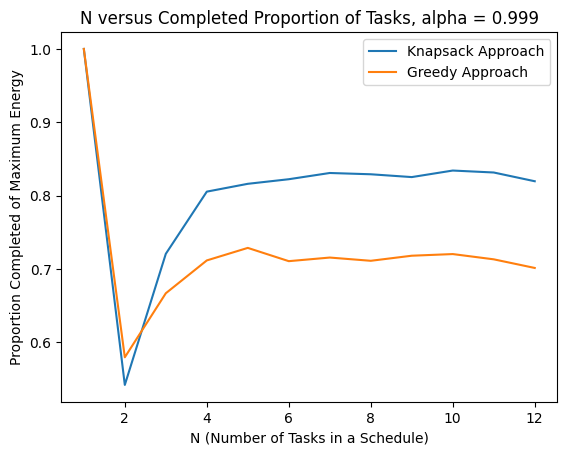

In [ ]:
# average % accomplished of tasks versus time
'''
This function generates the average amount of energy proportional to maximum energy completed
using the Greedy and Knapsack algorithms.
'''
def genAvEnergyVsTime(data, alpha, max_energy=12, max_time=12):
  # store the values of n or the count of tasks per sample set
  n = []
  # store the average proportions per algorithm
  av_proportion_completed_KP = []
  av_proportion_completed_Greedy = []
  # iterate over the dictionary of items
  for count, samples in data.items():
    # add to our n's
    n.append(count)
    # storing the total tasks over algo run
    total_tasks_completed_KP = 0
    total_tasks_completed_Greedy = 0
    for sample in samples:
      # per each sample generate knapsack and greedy output
      kp = genScheduleKnapsack(sample, alpha, max_energy, max_time)
      greedy = genScheduleGreedy(sample, alpha, max_energy, max_time)

      #sum the energy used per set
      av_sample_tasks_completed_KP = 0
      av_sample_tasks_completed_Greedy = 0
      for tKP, tG in zip(kp, greedy):
        av_sample_tasks_completed_KP += tKP[0]
        av_sample_tasks_completed_Greedy += tG[0]

      # normalize the proportion to the maximum energy
      total_tasks_completed_KP += av_sample_tasks_completed_KP / max_energy
      total_tasks_completed_Greedy += av_sample_tasks_completed_Greedy / max_energy
    # take the average of the total tasks completed proportionally
    av_proportion_completed_KP.append(total_tasks_completed_KP / len(samples))
    av_proportion_completed_Greedy.append(total_tasks_completed_Greedy/len(samples))
  plt.plot(n, av_proportion_completed_KP, label="Knapsack Approach")
  plt.plot(n, av_proportion_completed_Greedy, label="Greedy Approach")
  plt.xlabel("N (Number of Tasks in a Schedule)")
  plt.ylabel("Proportion Completed of Maximum Energy")
  plt.legend()
  plt.title("N versus Completed Proportion of Tasks, alpha = 0.999")
  plt.show()

genAvEnergyVsTime(data, 0.999)

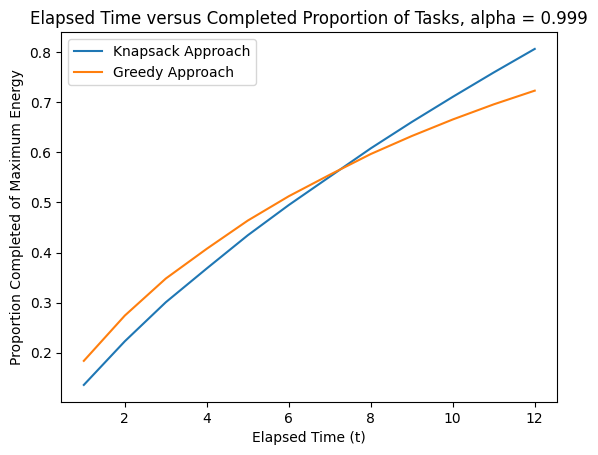

In [ ]:
'''
This function generates a plot of time markers in terms of hours and proportion
of tasks completed per hour for each approach regardless of n for the entire
sample set. It's aggregate across samples of n as each sample of n has equal
weight in the outcome.
'''
def genAvEnergyVsTime(data, alpha, max_energy=12, max_time=12):
  # list of time in hours
  time_points = list(range(1, max_time + 1))  # Elapsed time points to consider
  # keep track of proportion of tasks completed on average at each hour marker
  av_proportion_completed_KP = [0] * max_time
  av_proportion_completed_Greedy = [0] * max_time

  # Calculate total number of samples
  total_samples = sum(len(samples) for samples in data.values())

  # iterate through the samples ignoring the count
  for _, samples in data.items():
    for sample in samples:
      # generate the schedule per method
      kp_schedule = genScheduleKnapsack(sample, alpha, max_energy, max_time)
      greedy_schedule = genScheduleGreedy(sample, alpha, max_energy, max_time)

      for t in time_points:
        # energy used by Knapsack up to time t
        kp_energy_at_t = sum(task[0] for task in kp_schedule if task[1] <= t)
        # energy used by Greedy up to time t
        greedy_energy_at_t = sum(task[0] for task in greedy_schedule if task[1] <= t)

        # accumulate Knapsack proportion for time t
        av_proportion_completed_KP[t - 1] += kp_energy_at_t / max_energy
        # accumulate Greedy proportion for time t
        av_proportion_completed_Greedy[t - 1] += greedy_energy_at_t / max_energy

  # average proportions across samples
  av_proportion_completed_KP = [prop / total_samples for prop in av_proportion_completed_KP]
  av_proportion_completed_Greedy = [prop / total_samples for prop in av_proportion_completed_Greedy]

  # plot
  plt.plot(time_points, av_proportion_completed_KP, label="Knapsack Approach")
  plt.plot(time_points, av_proportion_completed_Greedy, label="Greedy Approach")
  plt.xlabel("Elapsed Time (t)")
  plt.ylabel("Proportion Completed of Maximum Energy")
  plt.legend()
  plt.title("Elapsed Time versus Completed Proportion of Tasks, alpha = 0.999")
  plt.show()

genAvEnergyVsTime(data, 0.999)

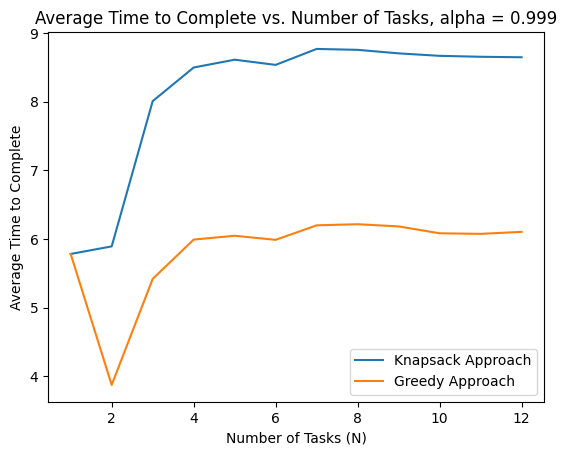

In [ ]:
def genAvTimeVsN(data, alpha, max_energy=12, max_time=12):
  # store values of n
  n_values = []
  # store average time for knapsack
  avg_time_kp = []
  # store average time for Greedy
  avg_time_greedy = []

  for n, samples in data.items():
    # store n count
    n_values.append(n)
    # total time per algo
    total_time_kp = 0
    total_time_greedy = 0

    for sample in samples:
      # per each sample generate the schedule and the total time
      kp_schedule = genScheduleKnapsack(sample, alpha, max_energy, max_time)
      greedy_schedule = genScheduleGreedy(sample, alpha, max_energy, max_time)

      # calculate total time for each schedule
      total_time_kp += sum(task[1] for task in kp_schedule)
      total_time_greedy += sum(task[1] for task in greedy_schedule)

    # calculate average time for each algorithm
    avg_time_kp.append(total_time_kp / len(samples))
    avg_time_greedy.append(total_time_greedy / len(samples))

  # plot
  plt.plot(n_values, avg_time_kp, label="Knapsack Approach")
  plt.plot(n_values, avg_time_greedy, label="Greedy Approach")
  plt.xlabel("Number of Tasks (N)")
  plt.ylabel("Average Time to Complete")
  plt.title("Average Time to Complete vs. Number of Tasks, alpha = 0.999")
  plt.legend()
  plt.show()

genAvTimeVsN(data, 0.999)

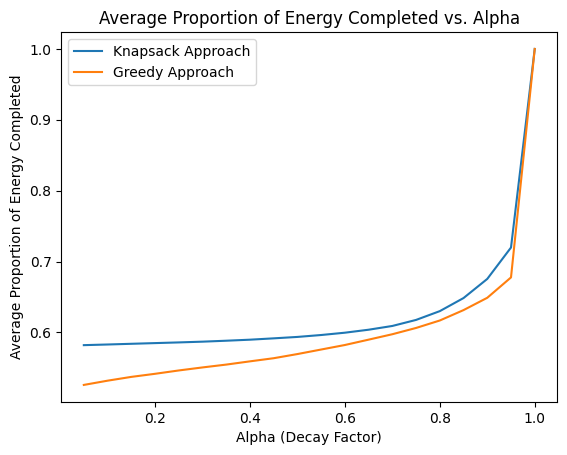

In [ ]:
def genAvEnergyVsAlpha(data, max_energy=12, max_time=12):
  # Alpha values from 0.1 to 1 in 0.1 increments
  alpha_values = [i * 0.05 for i in range(1, 21)]
  # store average times per algorithm
  avg_energy_prop_kp = []
  avg_energy_prop_greedy = []

  for alpha in alpha_values:
    total_energy_kp = 0
    total_energy_greedy = 0
    total_samples = 0  # Track total number of samples

    for _, samples in data.items():
      total_samples += len(samples)  # Update total samples count

      for sample in samples:
        kp_schedule = genScheduleKnapsack(sample, alpha, max_energy, max_time)
        greedy_schedule = genScheduleGreedy(sample, alpha, max_energy, max_time)

        total_energy_kp += sum(task[0] for task in kp_schedule)
        total_energy_greedy += sum(task[0] for task in greedy_schedule)

    # Calculate average time for each algorithm
    avg_energy_prop_kp.append(total_energy_kp / (total_samples * max_energy))
    avg_energy_prop_greedy.append(total_energy_greedy / (total_samples * max_energy))

  # Plotting
  plt.plot(alpha_values, avg_energy_prop_kp, label="Knapsack Approach")
  plt.plot(alpha_values, avg_energy_prop_greedy, label="Greedy Approach")
  plt.xlabel("Alpha (Decay Factor)")
  plt.ylabel("Average Proportion of Energy Completed")
  plt.title("Average Proportion of Energy Completed vs. Alpha")
  plt.legend()
  plt.show()

genAvEnergyVsAlpha(data)